# Построение выборки для модели кредитного скоринга - 1 (разведочный анализ + WOE)

Загрузим данные соревнования https://www.kaggle.com/c/home-credit-default-risk/overview

In [3]:
! kaggle competitions download -c home-credit-default-risk

100%|█████████████████████████████████████████| 688M/688M [17:56<00:00, 686kB/s]



In [4]:
! mkdir data

In [6]:
import zipfile
with zipfile.ZipFile("home-credit-default-risk.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Посмотрим на данные. Отметим, что признаков очень много: 122.

In [3]:
application = pd.read_csv('data/application_train.csv')
application.sample(7, random_state=57)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
170430,297531,0,Cash loans,M,Y,N,0,157500.0,679500.0,27076.5,679500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.026392,-14705,-7272,-6238.0,-220,8.0,1,1,0,1,1,0,Drivers,2.0,2,2,SATURDAY,17,0,0,0,0,0,0,Industry: type 7,0.342672,0.570747,0.332851,0.1206,NaN,0.9916,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1478,NaN,0.0037,0.1229,NaN,0.9916,NaN,NaN,0.1611,0.1379,0.3333,NaN,NaN,NaN,0.1540,NaN,0.0039,0.1218,NaN,0.9916,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1504,NaN,0.0037,NaN,block of flats,0.1170,Others,No,0.0,0.0,0.0,0.0,-2252.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
77136,189440,0,Cash loans,F,Y,Y,0,220500.0,432567.0,19183.5,328500.0,Family,Working,Secondary / secondary special,Separated,House / apartment,0.018029,-20590,-708,-1768.0,-4081,11.0,1,1,0,1,0,0,Laborers,1.0,3,3,TUESDAY,13,0,0,0,0,0,0,Government,0.788965,0.090318,0.764939,0.0722,NaN,0.9846,NaN,NaN,0.00,0.0345,0.2083,NaN,NaN,NaN,0.0422,NaN,0.0000,0.0735,NaN,0.9846,NaN,NaN,0.0000,0.0345,0.2083,NaN,NaN,NaN,0.0439,NaN,0.0000,0.0729,NaN,0.9846,NaN,NaN,0.00,0.0345,0.2083,NaN,NaN,NaN,0.0429,NaN,0.0000,NaN,block of flats,0.0395,Panel,No,0.0,0.0,0.0,0.0,-119.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,7.0
236101,373468,0,Cash loans,F,Y,Y,0,90000.0,254700.0,14350.5,225000.0,Family,Pensioner,Secondary / secondary special,Married,House / apartment,0.035792,-23878,365243,-9575.0,-4358,15.0,1,0,0,1,1,0,NaN,2.0,2,2,MONDAY,13,0,0,0,1,0,0,XNA,0.841625,0.295620,0.656158,0.0897,NaN,0.9816,NaN,NaN,NaN,0.2069,0.1667,NaN,0.0908,NaN,0.0766,NaN,0.0098,0.0914,NaN,0.9816,NaN,NaN,NaN,0.2069,0.1667,NaN,0.0928,NaN,0.0799,NaN,0.0104,0.0906,NaN,0.9816,NaN,NaN,NaN,0.2069,0.1667,NaN,0.0923,NaN,0.0780,NaN,0.0100,NaN,block of flats,0.0700,"Stone, bric

In [4]:
application.shape

(307511, 122)

С таким большим количеством колонок работать неудобно. Разобьем их на группы.

In [5]:
FLAG_DOCUMENT_GROUP = ['FLAG_DOCUMENT_%s' % i for i in range(2, 22)]
TARGET_GROUP = ['TARGET']
GENERAL_BIO_GROUP = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                     'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                     'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
                     'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                     'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'ORGANIZATION_TYPE',
                     'OWN_CAR_AGE', 'DAYS_LAST_PHONE_CHANGE']
DAYS_BIO_GROUP = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
AMT_GROUP = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'] + [
    'AMT_REQ_CREDIT_BUREAU_%s' % i for i in ['HOUR', 'DAY', 'WEEK', 'MON', 'QRT', 'YEAR']]
REGION_GROUP = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 
                'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
                'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'REGION_POPULATION_RELATIVE']
APARTMENT_GROUP = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                   'COMMONAREA_AVG', 'ELEVATORS_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                   'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                   'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
                   'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                   'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
                   'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
                   'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                   'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
                   'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                   'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
                   'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
SOCIAL_CIRCLE_GROUP = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
APPR_PROCESS_GROUP = ['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START']
EXT_SOURCE_GROUP = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
OTHER_GROUP = ['ENTRANCES_AVG', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE']



In [6]:
ALL_COLUMNS = set(application.columns)
COLUMNS_IN_GROUPS = FLAG_DOCUMENT_GROUP + TARGET_GROUP + GENERAL_BIO_GROUP + DAYS_BIO_GROUP +\
                    AMT_GROUP + REGION_GROUP + APARTMENT_GROUP + SOCIAL_CIRCLE_GROUP +\
                    APPR_PROCESS_GROUP + EXT_SOURCE_GROUP + OTHER_GROUP
print(len(ALL_COLUMNS) == len(COLUMNS_IN_GROUPS), len(ALL_COLUMNS), len(COLUMNS_IN_GROUPS))
print(set(COLUMNS_IN_GROUPS) == set(ALL_COLUMNS), set(ALL_COLUMNS) - set(COLUMNS_IN_GROUPS))

True 122 122
True set()


Посмотрим на различные общие статистики по данным

In [7]:
column_statistics = pd.DataFrame(index=application.columns)
column_statistics['CountNaN'] = application.isna().sum()
column_statistics['RateNaN%'] = (application.isna().sum() / application.shape[0] * 100).astype(int)
column_statistics['CountUnique'] = application.nunique()
described = application.describe()
column_statistics['MinValue'] = described.loc['min']
column_statistics['MaxValue'] = described.loc['max']
column_statistics['Mean'] = described.loc['mean']
column_statistics['Std'] = described.loc['std']
column_statistics['Median'] = described.loc['50%']

In [8]:
column_statistics

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
SK_ID_CURR,0,0,307511,1.000020e+05,4.562550e+05,278180.518577,102790.175348,278202.000000
TARGET,0,0,2,0.000000e+00,1.000000e+00,0.080729,0.272419,0.000000
NAME_CONTRACT_TYPE,0,0,2,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,0,0,3,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,0,0,2,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,0,0,2,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,0,0,15,0.000000e+00,1.900000e+01,0.417052,0.722121,0.000000
AMT_INCOME_TOTAL,0,0,2548,2.565000e+04,1.170000e+08,168797.919297,237123.146279,147150.000000
AMT_CREDIT,0,0,5603,4.500000e+04,4.050000e+06,599025.999706,402490.776996,513531.000000
AMT_ANNUITY,12,0,13672,1.615500e+03,2.580255e+05,27108.573909,14493.737315,24903.000000


In [9]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

Функции для составления/визуализации статистик

In [19]:
def draw_pies_for_columns(columns, df):
    for col in columns:
        counts = Counter(df[col])
        df = pd.DataFrame.from_dict(counts, orient='index')
        df.index.name = col
        df.columns = ['count']
        df.plot(kind='pie', rot=0, figsize=(5, 5), y='count', autopct='%1.1f%%')
        plt.title('Data distribution by %s' % col)
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()
        
def draw_hists_for_categorical_columns(columns, df):
    for col in columns:
        counts = Counter(df[col])
        df = pd.DataFrame.from_dict(counts, orient='index')
        df.index.name = col
        df.columns = ['count']
        df.plot(kind='bar', rot=0, figsize=(15,4))
        plt.title('Data distribution by %s' % col)
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()
        
def draw_hists_for_numerical_columns(columns, df):
    for col in columns:
        plt.figure(figsize=(16,6))
        plt.hist(df[col], bins=50)
        plt.title('Data distribution by %s' % col)
        plt.xlabel(col)
        plt.show()

def draw_correlations_for_numerical_columns(columns, df):
    plt.figure(figsize=(18, 18))
    cor = df[columns].corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()

def get_df_general_stats(df):
    column_statistics = pd.DataFrame(index=df.columns)
    column_statistics['CountNaN'] = df.isna().sum()
    column_statistics['RateNaN%'] = (df.isna().sum() / df.shape[0] * 100).astype(int)
    column_statistics['CountUnique'] = df.nunique()
    described = df.describe()
    column_statistics['MinValue'] = described.loc['min']
    column_statistics['MaxValue'] = described.loc['max']
    column_statistics['Mean'] = described.loc['mean']
    column_statistics['Std'] = described.loc['std']
    column_statistics['Median'] = described.loc['50%']
    return column_statistics

С данными целиком работать сложно, поэтому для начала посмотрим на различные группы.

## Анализ групп признаков

### GENERAL_BIO_GROUP - общие признаки клиента

In [12]:
general_bio_application = application[GENERAL_BIO_GROUP]

In [13]:
general_bio_application.sample(7, random_state=57)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,OWN_CAR_AGE,DAYS_LAST_PHONE_CHANGE
170430,M,Y,N,0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Drivers,1,1,0,1,1,0,2.0,Industry: type 7,8.0,-2252.0
77136,F,Y,Y,0,Family,Working,Secondary / secondary special,Separated,House / apartment,Laborers,1,1,0,1,0,0,1.0,Government,11.0,-119.0
236101,F,Y,Y,0,Family,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,1,0,0,1,1,0,2.0,XNA,15.0,-2400.0
139065,F,N,Y,0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,1,0,0,1,0,0,2.0,XNA,NaN,-1695.0
240305,M,Y,N,0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1,1,0,1,0,0,1.0,Trade: type 7,10.0,-1479.0
128737,M,Y,N,0,Unaccompanied,Working,Higher education,Married,With parents,Managers,1,1,1,1,0,0,2.0,Business Entity Type 3,8.0,-2747.0
37088,M,Y,Y,0,Family,Working,Secondary / secondary special,Married,House / apartment,Laborers,1,1,0,1,1,0,2.0,Business Entity Type 2,14.0,-1133.0


In [15]:
get_df_general_stats(general_bio_application)

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
CODE_GENDER,0,0,3,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,0,0,2,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,0,0,2,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,0,0,15,0.0,19.0,0.417052,0.722121,0.0
NAME_TYPE_SUITE,1292,0,7,NaN,NaN,NaN,NaN,NaN
NAME_INCOME_TYPE,0,0,8,NaN,NaN,NaN,NaN,NaN
NAME_EDUCATION_TYPE,0,0,5,NaN,NaN,NaN,NaN,NaN
NAME_FAMILY_STATUS,0,0,6,NaN,NaN,NaN,NaN,NaN
NAME_HOUSING_TYPE,0,0,6,NaN,NaN,NaN,NaN,NaN
OCCUPATION_TYPE,96391,31,18,NaN,NaN,NaN,NaN,NaN


Признаки с пропусками в данных: NAME_TYPE_SUITE, OCCUPATION_TYPE, OWN_CAR_AGE. Посмотрим на них отдельно, чтобы понять, что лучше сделать с пропусками.

#### NAME_TYPE_SUITE

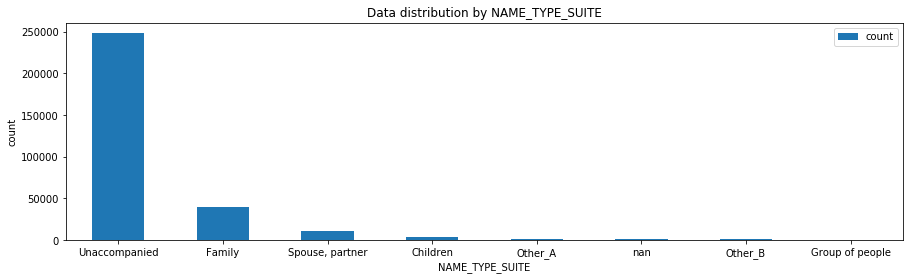

In [20]:
draw_hists_for_categorical_columns(['NAME_TYPE_SUITE'], general_bio_application)

Заметим, что во всех колонках, кроме Unaccompanied и Family очень мало клиентов.

Поэтому объединим их вместе с Family в одну колонку Accompanied.

In [21]:
def update_data_NAME_TYPE_SUITE(df):
    df.loc[df['NAME_TYPE_SUITE'] != 'Unaccompanied', 'NAME_TYPE_SUITE'] = 'Accompanied'

In [22]:
update_data_NAME_TYPE_SUITE(general_bio_application)

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


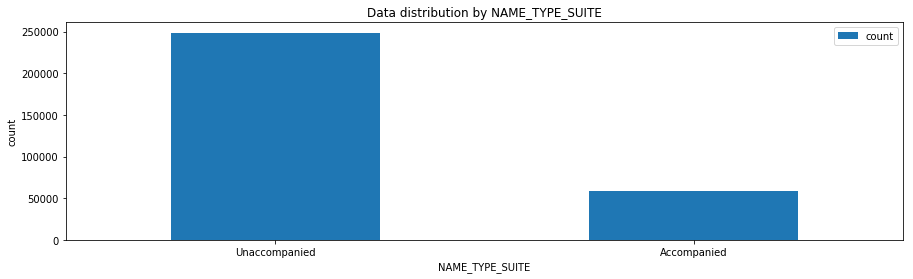

In [23]:
draw_hists_for_categorical_columns(['NAME_TYPE_SUITE'], general_bio_application)